In [ ]:
import os.path
import glob
import shutil

import tensorflow as tf
assert tf.__version__.startswith('2')

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,Flatten,MaxPooling2D,Dropout,Dense,Activation
from keras import regularizers
import keras

import numpy as np
import matplotlib.pyplot as plt
import pathlib

from numpy import loadtxt
import pandas as pd


In [ ]:
df = pd.read_csv("Train.csv")
test=pd.read_csv("Test.csv")

In [ ]:
df

,Image_id,Label
0,id_004wknd7qd.jpg,blast
1,id_004wknd7qd_rgn.jpg,blast
2,id_005sitfgr2.jpg,brown
3,id_005sitfgr2_rgn.jpg,brown
4,id_00stp9t6m6.jpg,blast
...,...,...
5335,id_zz6gzk7p97_rgn.jpg,brown
5336,id_zz8ca2p67e.jpg,blast
5337,id_zz8ca2p67e_rgn.jpg,blast
5338,id_zzt8y9q0x0.jpg,brown


In [ ]:
df['Image_id']

0           id_004wknd7qd.jpg
1       id_004wknd7qd_rgn.jpg
2           id_005sitfgr2.jpg
3       id_005sitfgr2_rgn.jpg
4           id_00stp9t6m6.jpg
                ...          
5335    id_zz6gzk7p97_rgn.jpg
5336        id_zz8ca2p67e.jpg
5337    id_zz8ca2p67e_rgn.jpg
5338        id_zzt8y9q0x0.jpg
5339    id_zzt8y9q0x0_rgn.jpg
Name: Image_id, Length: 5340, dtype: object

In [ ]:
df['Label'].unique()

array(['blast', 'brown', 'healthy'], dtype=object)

In [ ]:
BATCH_SIZE = 8
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import zipfile

local_zip = '/content/gdrive/MyDrive/Images (1).zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/Images')
zip_ref.close()

In [ ]:
for i in range(len(df)):
  df['Image_id'][i] ='/content/Images/' + df['Image_id'][i]

In [ ]:
df.drop(df[df.Image_id.str.endswith('rgn.jpg')].index, inplace = True)

In [ ]:
from sklearn import model_selection

x_train , xvalid =model_selection.train_test_split(df, test_size=0.2, train_size=None, random_state=None, shuffle=True, stratify=None)

Data augmentation

In [ ]:
image_train_gen = ImageDataGenerator(rescale=1./255,
                                     zoom_range=0.50,
                                     rotation_range=45,
                                     horizontal_flip=True,
                                     width_shift_range=0.15,
                                     height_shift_range=0.15)

train_data_gen = image_train_gen.flow_from_dataframe(dataframe=x_train,
                                        x_col="Image_id", y_col="Label",
                                        class_mode="categorical",
                                        target_size=(IMG_HEIGHT,IMG_WIDTH), batch_size=BATCH_SIZE)
img_val_gen = image_train_gen.flow_from_dataframe(dataframe=xvalid ,
                                        x_col="Image_id", y_col="Label",
                                        class_mode="categorical",target_size=(IMG_HEIGHT,IMG_WIDTH))
                       




Found 2136 validated image filenames belonging to 3 classes.
Found 534 validated image filenames belonging to 3 classes.


Data visualisation

In [ ]:
def plotImages(image_arr):
    fig,axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img,ax in zip(image_arr,axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

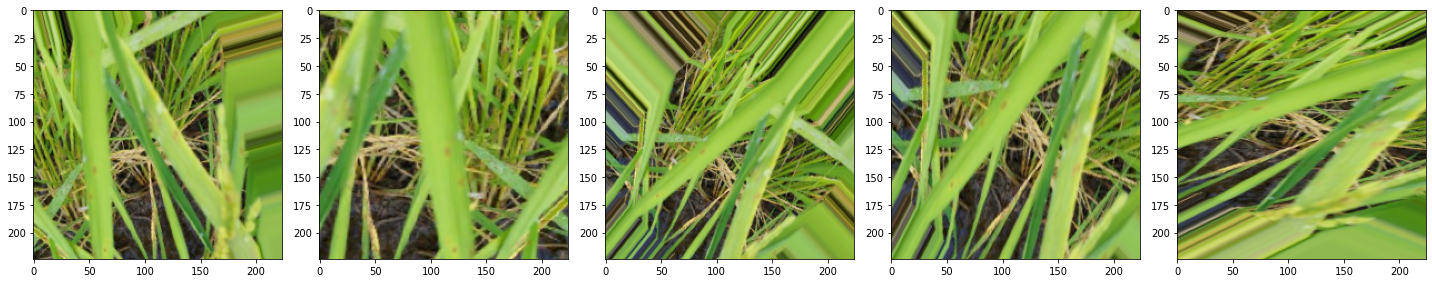

In [ ]:
# Plot a few training images
for i in range(5):
    img_array = [train_data_gen[0][0][0] for i in range(5)]
plotImages(img_array)

Building Model 


In [ ]:
model = Sequential()
model.add(Conv2D(16, (3,3), input_shape=(224,224,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(3, activation="softmax"))

model.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = ['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 26, 26, 64)      

In [ ]:
EPOCHS=50
history = model.fit_generator(train_data_gen, epochs=EPOCHS, validation_data=img_val_gen)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
267/267 [==============================] - 38s 139ms/step - loss: 0.9559 - accuracy: 0.5796 - val_loss: 0.9423 - val_accuracy: 0.5749
Epoch 2/50
267/267 [==============================] - 36s 136ms/step - loss: 0.8926 - accuracy: 0.6152 - val_loss: 0.9683 - val_accuracy: 0.5431
Epoch 3/50
267/267 [==============================] - 37s 139ms/step - loss: 0.8831 - accuracy: 0.6166 - val_loss: 0.9162 - val_accuracy: 0.5674
Epoch 4/50
267/267 [==============================] - 36s 136ms/step - loss: 0.8643 - accuracy: 0.6217 - val_loss: 0.8605 - val_accuracy: 0.6161
Epoch 5/50
267/267 [==============================] - 38s 142ms/step - loss: 0.8361 - accuracy: 0.6353 - val_loss: 0.8429 - val_accuracy: 0.6330
Epoch 6/50
267/267 [==============================] - 37s 137ms/step - loss: 0.8070 - accuracy: 0.6699 - val_loss: 0.8122 - val_accuracy: 0.6554
Epoch 7/50
267/267 [==============================] - 36s 137ms/step - loss: 0.7875 - accuracy: 0.6723 - val_loss: 0.7884 - val_ac